April 2020 CME event

https://github.com/helioforecast/Papers/blob/master/Moestl2020_PSP_rate/psp_3dcore.ipynb

In [10]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
import astropy
import astropy.constants as const
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import multiprocessing
import sunpy
import sunpy.time
from sunpy.time import parse_time


import py3dcore
import heliosat

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib import rc


#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script psp_3dcore.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
    
    
animdirectory='results/animations'
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)
    
#rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


[psp, bepi, solo, sta, earth, venus, mars, mercury,frame]= \
      pickle.load( open( 'data/positions_psp_solo_bepi_sta_planets_HEEQ_1hour.p', "rb" ))

In [50]:
############### Model Settings
t_launch = datetime.datetime(2020, 4, 15, 00)

iparams_arr = np.array([[
    0,      # time offset
    0,    # l_1 (logitude)
    0,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.20,   # d_1au (frontal width at 1AU)
    4,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    350,    # v_0 (initial velocty in)
    -2,      # tau (magnetic field twist)
    1,      # b_s (magnetic field scaling parameter)
    15,     #  b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    300,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


TP_A =  t_launch + datetime.timedelta(hours=24)
TP_B =  t_launch + datetime.timedelta(hours=72)

C_A = "xkcd:red"
C_B = "xkcd:blue"

C0 = "xkcd:black"
C1 = "xkcd:magenta"
C2 = "xkcd:orange"
C3 = "xkcd:azure"

#obj = py3dcore.abc.smc.ABCSMC()
#obj.load('data/APRIL_PARAMS.DAT')
#parameter sind unter obj.particles



### functions 

In [51]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    
    #time resolution in minutes
    res_in_days=1/(24*60.)    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    #print('data points',len(t_s))
    
    
    o_s = inst.trajectory(t_s, frame=frame)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b


#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*10 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    for p in np.arange(-2,2,0.2):
        ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
        ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .12)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3)    
    
    
    

def plot_3dcore_field(ax, obj, steps=500, step_size=0.005, **kwargs):
    q0 = kwargs.get("q0", np.array([1, .1, np.pi/2], dtype=np.float32)).astype(np.float32)

    fl = obj.visualize_fieldline(q0, steps=steps, step_size=step_size)

    ax.plot(*fl.T, **kwargs)

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        #ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
        
def plot_shift(axis,extent,cx,cy,cz):
    #shift center of plot
    axis.set_xbound(cx-extent, cx+extent)
    axis.set_ybound(cy-extent, cy+extent)
    axis.set_zbound(cz-extent*0.75, cz+extent*0.75)
    
    
  

### measure fields

In [52]:
#t1, btot1, bxyz1 = measure(model_obj, "PSP",  t_launch, TP_A  + datetime.timedelta(hours=6), frame="HEEQ", bframe="HEEQ")
#t2, btot2, bxyz2 = measure(model_obj, "PSP",  t_launch, TP_B  + datetime.timedelta(hours=12), frame="HEEQ", bframe="HEEQ")
t1, btot1, bxyz1 = measure(model_obj, "SOLO", t_launch, TP_B  + datetime.timedelta(hours=96), frame="HEEQ", bframe="SOLO_SUN_RTN")
t2, btot2, bxyz2 = measure(model_obj, "Earth", t_launch, TP_B  + datetime.timedelta(hours=96), frame="HEEQ", bframe="HEEQ")

### simple position plot

current frame_time_num 2020-04-19 05:07:00+00:00


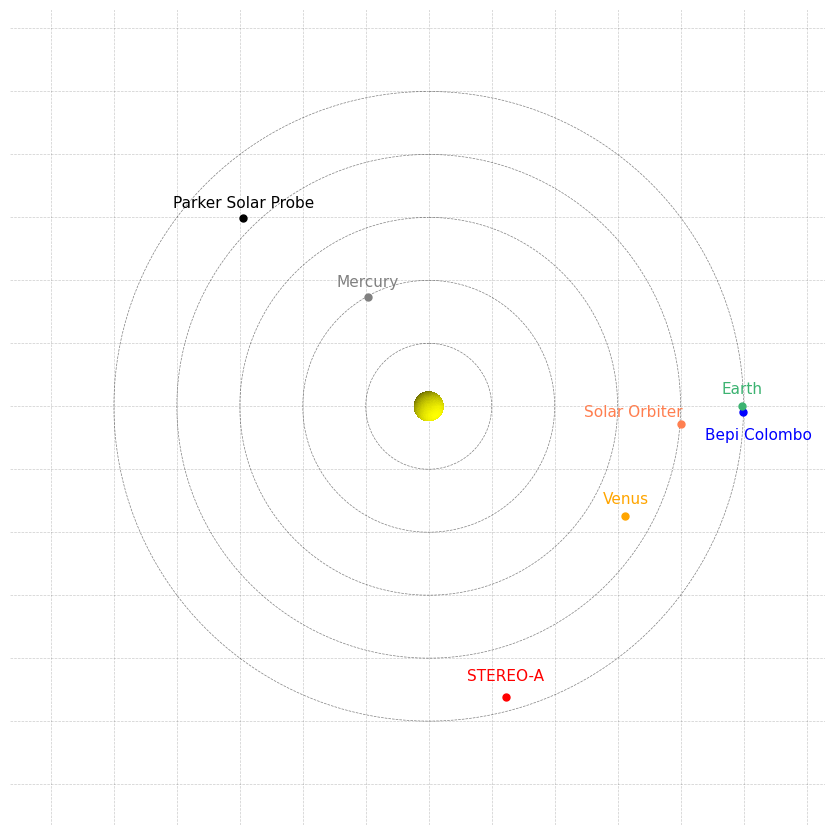

In [53]:
sns.set_style('whitegrid')


fig = plt.figure(1,figsize=(19.2, 10.8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((1, 1), (0, 0),projection='3d')  


######### tilted view
plot_configure(ax1, view_azim=270, view_elev=90, view_radius=.8)

#impact time of CME at solar orbiter 2020-04-19 05:07 UT
ti = datetime.datetime(2020, 4, 19, 5,7,0)

#plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax1, "Earth", ti, frame="HEEQ", color='mediumseagreen')
plot_traj(ax1, "Venus", ti, frame="HEEQ", color='orange')
plot_traj(ax1, "Mercury", ti, frame="HEEQ", color='grey')
plot_traj(ax1, "SOLO", ti, frame="HEEQ", color='coral')
plot_traj(ax1, "PSP", ti, frame="HEEQ", color='black')
plot_traj(ax1, "STA", ti, frame="HEEQ", color='red')
plot_traj(ax1, "BEPI", ti, frame="HEEQ", color='blue')




frame_time_num=mdates.date2num(ti) 
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-(psp.time+ mdates.date2num(np.datetime64('0000-12-31')))
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-(bepi.time+ mdates.date2num(np.datetime64('0000-12-31')))
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-(solo.time+ mdates.date2num(np.datetime64('0000-12-31')))
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-(sta.time+ mdates.date2num(np.datetime64('0000-12-31')))
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-(earth.time+ mdates.date2num(np.datetime64('0000-12-31')))
earth_timeind=np.argmin(abs(dct))


fsize=15


#spacecraft labels

ax1.text(psp.x[psp_timeind],psp.y[psp_timeind]+0.07,psp.z[psp_timeind],'Parker Solar Probe', color='black', ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(solo.x[solo_timeind]-0.15,solo.y[solo_timeind]+0.07,solo.z[solo_timeind],'Solar Orbiter', color='coral', ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(bepi.x[bepi_timeind]+0.05,bepi.y[bepi_timeind]-0.05,bepi.z[bepi_timeind],'Bepi Colombo', color='blue', ha='center',fontsize=fsize-4,verticalalignment='top')
#ax1.text(bepi.x[bepi_timeind]-0.16,bepi.y[bepi_timeind],bepi.z[solo_timeind],'Colombo', color='blue', ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(sta.x[sta_timeind],sta.y[sta_timeind]+0.09,sta.z[sta_timeind],'STEREO-A', color='red', ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(earth.x[earth_timeind],earth.y[earth_timeind]+0.08,earth.z[earth_timeind],'Earth', color='mediumseagreen', ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(venus.x[earth_timeind],venus.y[earth_timeind]+0.08,venus.z[earth_timeind],'Venus', color='orange', ha='center',fontsize=fsize-4,verticalalignment='top')
ax1.text(mercury.x[earth_timeind],mercury.y[earth_timeind]+0.07,mercury.z[earth_timeind],'Mercury', color='grey', ha='center',fontsize=fsize-4,verticalalignment='top')

#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
r1=0.8
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

r1=0.6
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

r1=0.4
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )

r1=0.2
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )




a_circle = plt.Circle((0, 0), .5,fill=False,zorder=3,linestyle='-')
ax1.add_artist(a_circle)


plt.savefig('results/plots/positions_solo_apr2020_event.png', dpi=100,bbox_inches='tight')

#plt.savefig('results/plots/positions_solo_apr2020_event_tilt.png', dpi=100,bbox_inches='tight')

## model plot

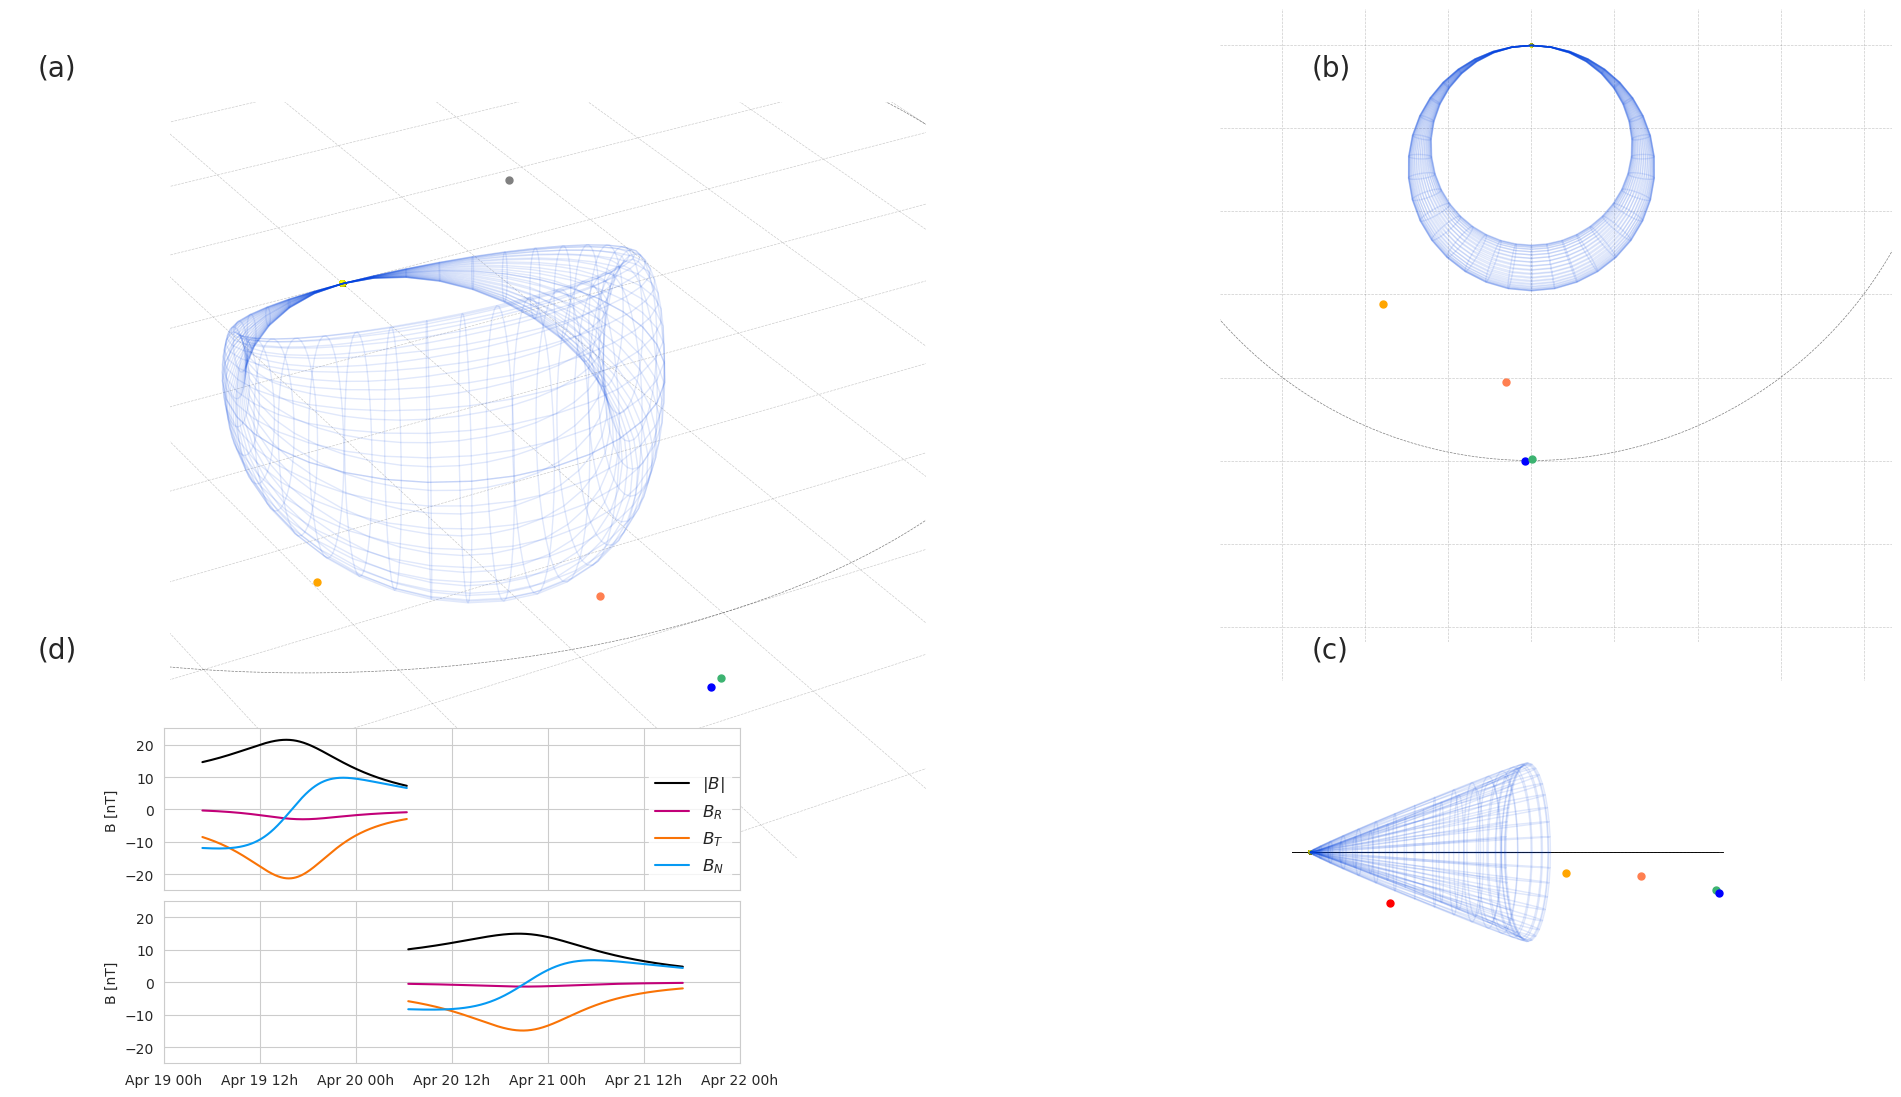

In [60]:
#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure2(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    

    
    #solar equatorial plane
    for p in np.arange(-2,2,0.2):
        ax.plot([-2,2],[p,p],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
        ax.plot([p,p],[-2,2],[0,0],lw=0.5,color='black', alpha=0.2,linestyle='--',zorder=0 )
    
    #draw sun        
    ls = LightSource(azdeg=140, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    ax.set_axis_off()





sns.set_style('whitegrid')


fig = plt.figure(1,figsize=(19.2, 10.8),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((4, 3), (0, 0),rowspan=2,colspan=2,projection='3d')  
ax2 = plt.subplot2grid((4, 3), (0, 2),projection='3d',rowspan=2)  
ax3 = plt.subplot2grid((4, 3), (2, 2),projection='3d',rowspan=2)  
ax4 = plt.subplot2grid((4, 3), (2, 0))  
ax5 = plt.subplot2grid((4, 3), (3, 0))  

#manually set axes positions
#https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
ax1.set_position([0,0.2,0.6,0.7], which='both')
ax2.set_position([0.65,0.35,0.35,0.65], which='both')
ax3.set_position([0.6,0,0.4,0.4], which='both')
ax4.set_position([0.10,0.17,0.3,0.15], which='both')
ax5.set_position([0.10,0.01,0.3,0.15], which='both')



######### tilted view
plot_configure2(ax1, view_azim=-30, view_elev=30, view_radius=.2)

plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax1, "Earth", TP_B, frame="HEEQ", color='mediumseagreen')
plot_traj(ax1, "SOLO", TP_B, frame="HEEQ", color='coral')
plot_traj(ax1, "Venus", TP_B, frame="HEEQ", color='orange')
plot_traj(ax1, "Mercury", TP_B, frame="HEEQ", color='grey')
plot_traj(ax1, "PSP", TP_B, frame="HEEQ", color='black')
plot_traj(ax1, "STA", TP_B, frame="HEEQ", color='red')
plot_traj(ax1, "BEPI", TP_B, frame="HEEQ", color='blue')


#plot_3dcore(ax1, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax1, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")#
#plot_traj(ax1, "Earth", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)

#dotted trajectory
#plot_traj(ax1, "Earth", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

#shift center
plot_shift(ax1,0.3,0.6,0.0,0)

########### top view panel
plot_configure2(ax2, view_azim=0, view_elev=90, view_radius=.4)
#plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
plot_3dcore(ax2, model_obj, TP_B, color=C_B)
plot_traj(ax2, "Earth", TP_B, frame="HEEQ", color='mediumseagreen')
plot_traj(ax2, "SOLO", TP_B, frame="HEEQ", color='coral')
plot_traj(ax2, "Venus", TP_B, frame="HEEQ", color='orange')
plot_traj(ax2, "Mercury", TP_B, frame="HEEQ", color='grey')
plot_traj(ax2, "PSP", TP_B, frame="HEEQ", color='black')
plot_traj(ax2, "STA", TP_B, frame="HEEQ", color='red')
plot_traj(ax2, "BEPI", TP_B, frame="HEEQ", color='blue')




#plot_3dcore_field(ax2, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
#plot_traj(ax2, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

#plot_3dcore(ax2, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax2, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
#plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
plot_shift(ax2,0.5,0.7,0.08,0.0)


############### edge on view panel
plot_configure2(ax3, view_azim=-90, view_elev=0, view_radius=.4)

plot_3dcore(ax3, model_obj, TP_B, color=C_B)
plot_traj(ax3, "Earth", TP_B, frame="HEEQ", color='mediumseagreen')
plot_traj(ax3, "SOLO", TP_B, frame="HEEQ", color='coral')
plot_traj(ax3, "Venus", TP_B, frame="HEEQ", color='orange')
plot_traj(ax3, "Mercury", TP_B, frame="HEEQ", color='grey')
plot_traj(ax3, "PSP", TP_B, frame="HEEQ", color='black')
plot_traj(ax3, "STA", TP_B, frame="HEEQ", color='red')
plot_traj(ax3, "BEPI", TP_B, frame="HEEQ", color='blue')



#plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
#plot_3dcore(ax3, model_obj, TP_A, color=C_A)
#plot_3dcore_field(ax3, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
#plot_traj(ax3, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

#plot_3dcore(ax3, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax3, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
#plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.0)

plot_shift(ax3,0.3,+0.5,-.5,0.0)



############################## magnetic field panel

#simtime1=np.round((parse_time(t3).plot_date-parse_time(t_launch).plot_date)*24,4)
#frametime=np.round((parse_time(TP_B).plot_date-parse_time(t_launch).plot_date)*24,1)


ax4.plot(t1, btot1, color=C0, label="$|B|$")
ax4.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
ax4.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
ax4.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")

ax4.legend(loc="lower right", fontsize=12,ncol=1,edgecolor='white')

ax4.set_ylabel('B [nT]')
ax4.set_xlim(datetime.datetime(2020,4,19,0,0),datetime.datetime(2020,4,22,0,0))
ax4.set_ylim(-25,25)


ax4.set_xticklabels([])

ax5.plot(t2, btot2, color=C0, label="$|B|$")
ax5.plot(t2, bxyz2[:, 0], color=C1, label="$B_R$")
ax5.plot(t2, bxyz2[:, 1], color=C2, label="$B_T$")
ax5.plot(t2, bxyz2[:, 2], color=C3, label="$B_N$")
ax5.set_ylabel('B [nT]')
ax5.set_xlim(datetime.datetime(2020,4,19,0,0),datetime.datetime(2020,4,22,0,0))
ax5.set_ylim(-25,25)
ax5.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %Hh'))

#ax4.set_xlim(datetime.datetime(2020,6,1,23,0),datetime.datetime(2022,6,3,4,0))

#line at current time
#ax4.plot([frametime[k],frametime[k]], [-2000,2000], color='black',linewidth=1,alpha=0.8)
#ax4.set_xlabel('hours since launch time')
#ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
#ax4.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#ax4.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(500))
#ax4.set_xlim(0,30)
#ax4.grid(True)




#write hours since launch time 
#plt.annotate('$t_{launch}$ +',[0.45,0.15],ha='center',xycoords='figure fraction',fontsize=20)
#plt.annotate(str(frametime),[0.5,0.15],ha='center',xycoords='figure fraction',fontsize=20)
#plt.annotate('hours',[0.54,0.15],ha='center',xycoords='figure fraction',fontsize=20)


#1 AU circle
p=np.arange(0,2*np.pi,0.01)
r1=1.0
ax1.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax2.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )
ax3.plot(r1*np.sin(p),r1*np.cos(p),0,lw=0.5,color='black', alpha=0.5,linestyle='--',zorder=0 )



#panel labels
plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(c)',[0.69,0.40],xycoords='figure fraction',fontsize=20)
plt.annotate('(d)',[0.02,0.40],xycoords='figure fraction',fontsize=20)

#plt.savefig('results/plots/visual_solo1.pdf',bbox_inches='tight')
plt.savefig('results/plots/visual_solo1.png', dpi=100)#,bbox_inches='tight')


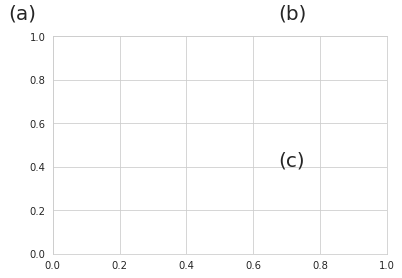

In [59]:
########### top view panel
plot_configure(ax2, view_azim=145-90, view_elev=90, view_radius=.08)
plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
plot_3dcore(ax2, model_obj, TP_A, color=C_A)
#plot_3dcore_field(ax2, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax2, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax2, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax2, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
plot_shift(ax2,0.09,-0.11,0.08,0.0)


############### edge on view panel
plot_configure(ax3, view_azim=145-90, view_elev=0, view_radius=.04)
plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
#plot_3dcore(ax3, model_obj, TP_A, color=C_A)
#plot_3dcore_field(ax3, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax3, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax3, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax3, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.0)

plot_shift(ax3,0.03,-0.05,0.0,0.0)


############### face on view panel
#plot_configure(ax4, view_azim=145, view_elev=0, view_radius=.12)
#plot_traj(ax4, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
#plot_3dcore(ax4, model_obj, TP_A, color=C_A)
#plot_3dcore_field(ax4, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
#plot_traj(ax4, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)
#plot_3dcore(ax4, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax4, model_obj, color=C_B, steps=850, step_size=0.001, lw=1.0, ls="-")
#plot_traj(ax4, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
#plot_shift(ax3,0.025,-0.03,0.0,0.0)


#panel labels
plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(c)',[0.69,0.40],xycoords='figure fraction',fontsize=20)

#plt.savefig('results/plots/visual_solo1.pdf',bbox_inches='tight')
plt.savefig('results/plots/visual_solo1.png', dpi=300,bbox_inches='tight')

### Animation 

In [7]:
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})

  

def make_frame(k):
    
    fig = plt.figure(52,figsize=(19.2, 10.8),dpi=100)
    
    #define subplot grid
    ax1 = plt.subplot2grid((3, 3), (0, 0),rowspan=2,colspan=2,projection='3d')  
    ax2 = plt.subplot2grid((3, 3), (0, 2),projection='3d')  
    ax3 = plt.subplot2grid((3, 3), (1, 2),projection='3d')  
    ax4 = plt.subplot2grid((3, 3), (2, 0))  

    
    
    #ax4 = plt.subplot2grid((3, 3), (2, 2),projection='3d')  

    #manually set axes positions
    #https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
    ax1.set_position([0,0,0.6,1], which='both')
    ax2.set_position([0.65,0.35,0.35,0.65], which='both')
    ax3.set_position([0.6,0,0.4,0.4], which='both')
    ax4.set_position([0.1,0.1,0.5,0.25], which='both')


    
    steps1=400+k*60
    stepsize1=0.0005

    ######### tilted view
    plot_configure(ax1, view_azim=125, view_elev=40, view_radius=.08)

    #solar equatorial plane
    #for p in np.arange(-1,1,0.05):
    #    ax1.plot([-1,1],[p,p],[0,0],lw=0.5,color='black', alpha=0.4,linestyle='--',zorder=0 )
    #    ax1.plot([p,p],[-1,1],[0,0],lw=0.5,color='black', alpha=0.4,linestyle='--',zorder=0 )

    
    

    plot_3dcore2(ax1, model_obj, tlist[k], color=C_A)
    #plot_3dcore_field(ax1, model_obj, color=C_A, steps=steps1, step_size=stepsize1, lw=1.0, ls="-")

    plot_traj(ax1, "PSP",  tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax1, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

    #shift center
    plot_shift(ax1,0.11,-0.05,0.0,-0.1)


    ########### top view panel
    plot_configure(ax2, view_azim=145-90, view_elev=90, view_radius=.08)

    plot_3dcore2(ax2, model_obj,  tlist[k], color=C_A)
    #plot_3dcore_field(ax2, model_obj, color=C_A, steps=steps1,step_size=stepsize1, lw=1.0, ls="-")

    plot_traj(ax2, "PSP",tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
    plot_shift(ax2,0.09,-0.11,0.08,0.0)


    ############### edge on view panel
    plot_configure(ax3, view_azim=145-90, view_elev=0, view_radius=.04)

    plot_3dcore2(ax3, model_obj,  tlist[k], color=C_A)
    #plot_3dcore_field(ax3, model_obj, color=C_A, steps=steps1, step_size=stepsize1, lw=1.0, ls="-")

    plot_traj(ax3, "PSP", tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

    plot_shift(ax3,0.03,-0.05,0.0,0.0)    
    
    
    ############################## magnetic field panel
    
        
    ax4.plot(simtime3, btot3, color=C0, label="$|B|$")
    ax4.plot(simtime3, bxyz3[:, 0], color=C1, label="$B_R$")
    ax4.plot(simtime3, bxyz3[:, 1], color=C2, label="$B_T$")
    ax4.plot(simtime3, bxyz3[:, 2], color=C3, label="$B_N$")

    
    ax4.legend(loc="lower right", fontsize=12,ncol=4,edgecolor='white')
    #ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
    ax4.set_ylabel('B [nT]')
    ax4.set_ylim(-1300,1300)
    #ax4.set_xlim(datetime.datetime(2022,6,1,23,0),datetime.datetime(2022,6,3,4,0))

    #line at current time
    ax4.plot([frametime[k],frametime[k]], [-2000,2000], color='black',linewidth=1,alpha=0.8)
    ax4.set_xlabel('hours since launch time')
    ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
    ax4.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    ax4.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(500))
    ax4.set_xlim(0,30)
    ax4.grid(True)
    


    #write hours since launch time 
    plt.annotate('$t_{launch}$ +',[0.43,0.45],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate(str(frametime[k]),[0.5,0.45],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate('hours',[0.54,0.45],ha='center',xycoords='figure fraction',fontsize=20)
   

    #panel labels
    #plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(b)',[0.59,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(c)',[0.59,0.40],xycoords='figure fraction',fontsize=20)

    framestr = '%05i' % (k)  
    plt.savefig(animdirectory2+'/3dcore_psp_'+framestr+'.jpg',dpi=100)
    print('frame:', k)
    #plt.close(52)



################## make animation    

#time for the animation as list
tlist=[]
for i in np.arange(1,2200,5):    
    tlist.append(t_launch+datetime.timedelta(minutes=float(i)))
    
print('number of frames',len(tlist))
#sns.set_style('whitegrid')


#simulation time since launch
frametime=np.round((parse_time(tlist).plot_date-parse_time(t_launch).plot_date)*24,1)

simtime3=np.round((parse_time(t3).plot_date-parse_time(t_launch).plot_date)*24,4)

#clock computing time
starttime1=time.time()

######## make frames
#make_frame2(40)

number of frames 440


NameError: name 't3' is not defined

In [ ]:
############################## multi

#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=100
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(len(tlist))]
pool.map(make_frame2, input)
pool.close()
# pool.join()


################################## single

#make all frames
#for k in np.arange(1,len(tlist)):
#    make_frame2(k)
    
#######################################    

os.system('ffmpeg -r 25 -i '+animdirectory2+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+outputdirectory+'/moestl2020_3dcore_psp_figure_5.mp4 -y -loglevel quiet')

print('movie finished in',np.round((time.time()-starttime1)/60,2),' minutes')